In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from time import time
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import random
random.seed(0)
import librosa
import warnings
warnings.filterwarnings("ignore")

## Reading File names

In [22]:
#Enter the root directory of your sound folder into path
path='./ML_data_G2'
# this is the list of all the instruments
instruments =['ney','setar','tar', 'violin','piano','santour']
files = []
labels =[]
for i in instruments:
    #first for loop iterates in each instrument folder
    file_path = path + '/'+ i
    for entry in os.listdir(file_path):
        #second for loop iterates through each file and adds it to the list if it ends with mp3 extention
        if entry.endswith('.mp3'):
            files.append(os.path.join(file_path, entry))
            labels.append(i)

print("found %d ney audio files"%(labels.count('ney')))
print("found %d setar audio files"%(labels.count('setar')))
print("found %d tar audio files"%(labels.count('tar')))
print("found %d violin audio files"%(labels.count('violin')))
print("found %d piano audio files"%(labels.count('piano')))
print("found %d santour audio files"%(labels.count('santour')))
print("Total number: %d "%(len(labels)))

found 216 ney audio files
found 223 setar audio files
found 187 tar audio files
found 165 violin audio files
found 227 piano audio files
found 226 santour audio files
Total number: 1244 


## Encoding labels

In [23]:
# encoding labels using LabelEncoder in sklearn
labelencoder = LabelEncoder()
labelencoder.fit(labels)
classes_num = labelencoder.transform(labels)

## Defining a Function to Extract Features

In [24]:
def get_features(y, sr=44100):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Chroma Spectogram
    rmse = librosa.feature.rms(y=y) #root mean square
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)#spectral centroid
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr) #spectral bandwidth
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr) #spectral roll off
    zcr = librosa.feature.zero_crossing_rate(y) #zero crossing rate
    mfcc = librosa.feature.mfcc(y=y, sr=sr) # mfc coefficients
    return mfcc,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr 

## Load audio files, calculate features and create feature vectors

In [25]:
feature_vectors = []
sound_paths = []
for f in tqdm(files):
        L = librosa.get_duration(filename=f) -20 #fist we calculate the duration of the input sound
        y, sr = librosa.load(f, sr=44100, duration=20, offset=random.randrange(int(L))) #then we sample 20 second from a random point in file
        #y/=y.max() #then we normalize the input so all sounds have same volume
        mfcc,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr = get_features(y) #then we extract the features
        #then add the whole features into a string file so we can add them all together into feature vector
        to_append = f'{np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        feature_vectors.append(to_append.split())
        #and add sound file path to sound_path 
        sound_paths.append(f)
#finally turning feature_vector into numpy array
feature_vectors = np.array(feature_vectors)
print("Calculated %d feature vectors"%len(feature_vectors))

100%|██████████████████████████████████████████████████████████████████████████████| 1244/1244 [27:36<00:00,  1.33s/it]

Calculated 1244 feature vectors


# Saving Results into hard drive

Saving files

In [46]:
with open('X.pickle', 'wb') as f: #saves file to hard disk
    pickle.dump(feature_vectors, f)
    
with open('labels.pickle', 'wb') as f: #saves file to hard disk
    pickle.dump(labels, f)

Loading files from hard drive

---

---
# *Classification* 
---

### Loading Data

In [47]:
with open('X.pickle', 'rb') as f: #loads the file from hard disk
    X = pickle.load(f)
    
with open('labels.pickle', 'rb') as f: #loads the file from hard disk
    labels = pickle.load(f)

### Labeling

In [48]:
# encoding labels using LabelEncoder in sklearn
labelencoder = LabelEncoder()
labelencoder.fit(labels)
y = labelencoder.transform(labels)

### Confusion Matrix Function

In [49]:
def plot_confusion_matrix(cm, classes, title, cmap='Blues'):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Scores

In [50]:
accuracy = []
f1_score = []
precision = []
recall = []
accuracy_cv = []
confusion_mtrx = []

### Train & Test Splitting

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

### Standardization

In [54]:
scaler = preprocessing.StandardScaler()
X_sclr = scaler.fit_transform(X)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

---

# KNN

### Finding best parameters

The best accuracy is 85.29 % with k = 4


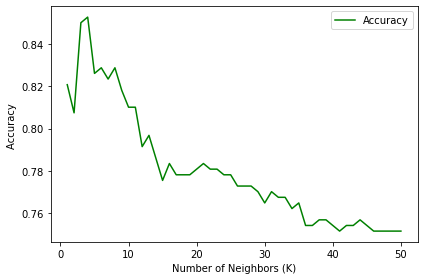

In [108]:
K = 50
acc = []
for n in range(1,K+1):
    clf = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = clf.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))

acc = np.array(acc)
print( "The best accuracy is", round(acc.max()*100, 2), "% with k =", acc.argmax()+1) 
plt.plot(range(1,K+1),acc,'g',label='Accuracy')
plt.legend()
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### Fitting

In [109]:
k = acc.argmax()+1
knn_clf = KNeighborsClassifier(n_neighbors = k)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

### Scores

In [110]:
f1_score.append(metrics.f1_score(y_test, y_pred, average='macro'))
precision.append(metrics.precision_score(y_test, y_pred, average='macro'))
recall.append(metrics.recall_score(y_test, y_pred, average='macro'))
accuracy.append(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.86        65
           1       0.92      1.00      0.96        68
           2       0.82      0.90      0.86        68
           3       0.83      0.87      0.85        67
           4       0.77      0.71      0.74        56
           5       0.82      0.82      0.82        50

    accuracy                           0.85       374
   macro avg       0.85      0.85      0.85       374
weighted avg       0.85      0.85      0.85       374



### Confusion Matrix

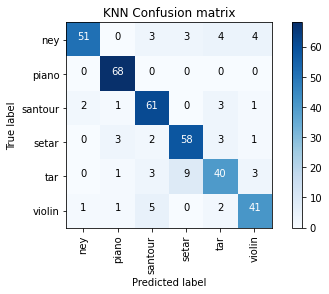

In [111]:
cnf_matrix = confusion_matrix(y_test, y_pred)
confusion_mtrx.append(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_ ,  title='KNN Confusion matrix')

### Cross Validation

In [112]:
clf = make_pipeline(preprocessing.StandardScaler(), knn_clf)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
accuracy_cv.append([scores.min(),scores.mean(),scores.max()])

print('lowest accuracy is', scores.min())
print('highest accuracy is', scores.max())
print('average accuracy is', scores.mean())

lowest accuracy is 0.784
highest accuracy is 0.888
average accuracy is 0.8352


---

# Decision Tree

### Finding best parameters

The accuracy of Decision Tree with max_depth = 9  is :  71.12 %


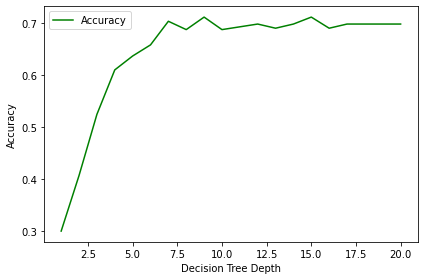

In [113]:
depths = 20
DTCA = []
for i in range(1,depths+1):
    clf = DecisionTreeClassifier(max_depth = i, class_weight='balanced', random_state=0)
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test)
    DTCA.append(accuracy_score(y_test, y_pred))

DTCA = np.array(DTCA)
print("The accuracy of Decision Tree with max_depth =", DTCA.argmax()+1 , " is : ", round(DTCA.max()*100, 2), "%")
plt.plot(range(1,depths+1), DTCA,'g',label='Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Decision Tree Depth')
plt.tight_layout()
plt.show()

### Fitting

In [114]:
d = DTCA.argmax()+1
dt_clf = DecisionTreeClassifier(max_depth = d, class_weight='balanced', random_state=0)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

### Scores

In [115]:
f1_score.append(metrics.f1_score(y_test, y_pred, average='macro'))
precision.append(metrics.precision_score(y_test, y_pred, average='macro'))
recall.append(metrics.recall_score(y_test, y_pred, average='macro'))
accuracy.append(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.65      0.65        65
           1       0.93      0.94      0.93        68
           2       0.74      0.66      0.70        68
           3       0.75      0.78      0.76        67
           4       0.53      0.52      0.52        56
           5       0.61      0.68      0.64        50

    accuracy                           0.71       374
   macro avg       0.70      0.70      0.70       374
weighted avg       0.71      0.71      0.71       374



### Confusion Matrix

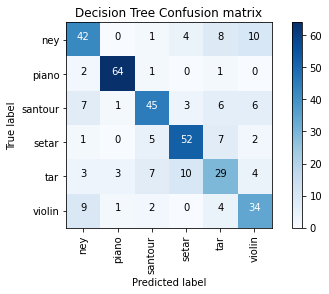

In [116]:
cnf_matrix = confusion_matrix(y_test, y_pred)
confusion_mtrx.append(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_ ,  title='Decision Tree Confusion matrix')

### Cross Validation

In [117]:
clf = make_pipeline(preprocessing.StandardScaler(), dt_clf)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
accuracy_cv.append([scores.min(),scores.mean(),scores.max()])

print('lowest accuracy is', scores.min())
print('highest accuracy is', scores.max())
print('average accuracy is', scores.mean())

lowest accuracy is 0.6370967741935484
highest accuracy is 0.792
average accuracy is 0.7322451612903226


---

# Logistic Regression

### Finding best parameters

In [118]:
model = LogisticRegression(class_weight='balanced', random_state=0)
clf = GridSearchCV(model, param_grid={'C':[.1, 10, 100],
                                      'max_iter':[50, 100, 500]})

clf.fit(X_sclr,y)
print('best parameters of the model are:',clf.best_params_)

best parameters of the model are: {'C': 10, 'max_iter': 100}


### Fitting

In [119]:
lr_clf = LogisticRegression(C=10, max_iter=100, class_weight='balanced', random_state=0)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)

### Scores

In [120]:
f1_score.append(metrics.f1_score(y_test, y_pred, average='macro'))
precision.append(metrics.precision_score(y_test, y_pred, average='macro'))
recall.append(metrics.recall_score(y_test, y_pred, average='macro'))
accuracy.append(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        65
           1       0.99      0.97      0.98        68
           2       0.86      0.93      0.89        68
           3       0.82      0.93      0.87        67
           4       0.76      0.55      0.64        56
           5       0.76      0.82      0.79        50

    accuracy                           0.86       374
   macro avg       0.85      0.85      0.84       374
weighted avg       0.85      0.86      0.85       374



### Confusion Matrix

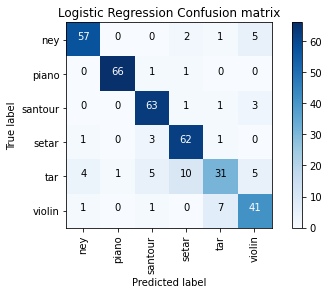

In [121]:
cnf_matrix = confusion_matrix(y_test, y_pred)
confusion_mtrx.append(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_ , title='Logistic Regression Confusion matrix')

### Cross Validation

In [122]:
clf = make_pipeline(preprocessing.StandardScaler(), lr_clf)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
accuracy_cv.append([scores.min(),scores.mean(),scores.max()])

print('lowest accuracy is', scores.min())
print('highest accuracy is', scores.max())
print('average accuracy is', scores.mean())

lowest accuracy is 0.8387096774193549
highest accuracy is 0.944
average accuracy is 0.8809548387096774


---

# SVM

### Finding best parameters

In [123]:
model = svm.SVC(class_weight='balanced', random_state=0)
clf = GridSearchCV(model, param_grid={'C':[.1, 10, 50], 
                                      'gamma':[.001, .01, .1], 
                                      'kernel':['rbf', 'poly', 'sigmoid']})
clf.fit(X_sclr,y)
print('best parameters of the model are:',clf.best_params_)

best parameters of the model are: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


### Fitting

In [124]:
svm_clf = svm.SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced', random_state=0)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

### Scores

In [125]:
f1_score.append(metrics.f1_score(y_test, y_pred, average='macro'))
precision.append(metrics.precision_score(y_test, y_pred, average='macro'))
recall.append(metrics.recall_score(y_test, y_pred, average='macro'))
accuracy.append(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        65
           1       0.97      1.00      0.99        68
           2       0.93      0.94      0.93        68
           3       0.84      0.93      0.88        67
           4       0.80      0.66      0.73        56
           5       0.88      0.76      0.82        50

    accuracy                           0.88       374
   macro avg       0.88      0.87      0.87       374
weighted avg       0.88      0.88      0.88       374



### Confusion Matrix

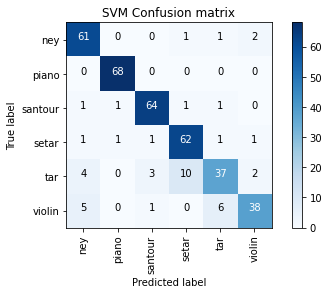

In [126]:
cnf_matrix = confusion_matrix(y_test, y_pred)
confusion_mtrx.append(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_ , title='SVM Confusion matrix')

### Cross Validation

In [127]:
clf = make_pipeline(preprocessing.StandardScaler(), svm_clf)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
accuracy_cv.append([scores.min(),scores.mean(),scores.max()])

print('lowest accuracy is', scores.min())
print('highest accuracy is', scores.max())
print('average accuracy is', scores.mean())

lowest accuracy is 0.8548387096774194
highest accuracy is 0.944
average accuracy is 0.9051419354838709


---

# MLP

### Finding best parameters

In [92]:
model = MLPClassifier(random_state=0, learning_rate='adaptive')
clf = GridSearchCV(model, param_grid={'activation':['logistic', 'tanh', 'relu'], 
                                      'learning_rate_init':[.001, .01, .1],
                                      'hidden_layer_sizes':[(200,), (100,50), (200,100), (300,200)]})
clf.fit(X_sclr,y)
print('best parameters of the model are:',clf.best_params_)

best parameters of the model are: {'activation': 'tanh', 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.001}


### Fitting

In [128]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(200,), activation='tanh', learning_rate_init=.001, max_iter=200, 
                        learning_rate='adaptive', random_state=0 )

mlp_clf.fit(X_train, y_train)

y_pred = mlp_clf.predict(X_test)

### MLP loss & accuracy curve

In [137]:
acc = []
for i in range(1,151):
    mlp_clf = MLPClassifier(hidden_layer_sizes=(200,), activation='tanh', learning_rate_init=.001, max_iter=i, 
                            learning_rate='adaptive', random_state=0 ).fit(X_train, y_train)
    acc.append(metrics.accuracy_score(y_test, mlp_clf.predict(X_test)))

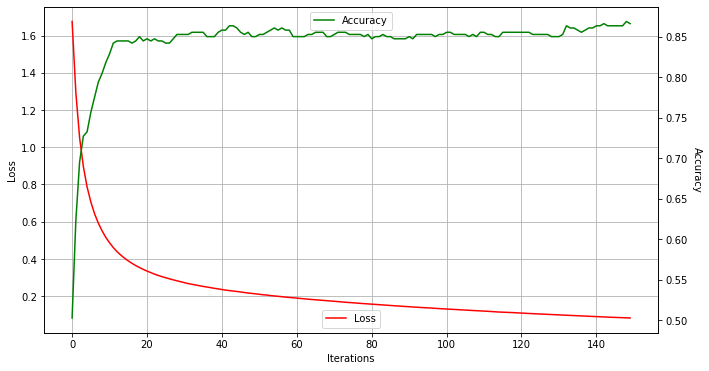

In [138]:
fig, ax = plt.subplots(figsize=(11,6))
ax1 = ax
ax1.plot(mlp_clf.loss_curve_, 'r', label='Loss')
ax1.set_ylabel('Loss')
ax2 = ax.twinx()
ax2.plot(acc, 'g', label='Accuracy')
ax2.set_ylabel('Accuracy', rotation=-90, labelpad=15)
ax.grid()
ax.set_xlabel('Iterations')
ax1.legend(loc=8)
ax2.legend(loc=9)
plt.show();

### Scores

In [129]:
f1_score.append(metrics.f1_score(y_test, y_pred, average='macro'))
precision.append(metrics.precision_score(y_test, y_pred, average='macro'))
recall.append(metrics.recall_score(y_test, y_pred, average='macro'))
accuracy.append(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        65
           1       1.00      0.99      0.99        68
           2       0.90      0.97      0.94        68
           3       0.85      0.90      0.87        67
           4       0.81      0.62      0.71        56
           5       0.78      0.86      0.82        50

    accuracy                           0.88       374
   macro avg       0.87      0.87      0.87       374
weighted avg       0.88      0.88      0.87       374



### Confusion Matrix

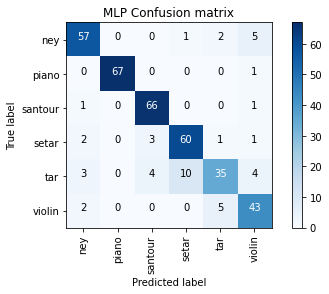

In [130]:
cnf_matrix = confusion_matrix(y_test, y_pred)
confusion_mtrx.append(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_ , title='MLP Confusion matrix')

### Cross Validation

In [131]:
clf = make_pipeline(preprocessing.StandardScaler(), mlp_clf)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
accuracy_cv.append([scores.min(),scores.mean(),scores.max()])

print('lowest accuracy is', scores.min())
print('highest accuracy is', scores.max())
print('average accuracy is', scores.mean())

lowest accuracy is 0.8629032258064516
highest accuracy is 0.9435483870967742
average accuracy is 0.9083419354838711


---

# Comparison

### Diffrent Metrics

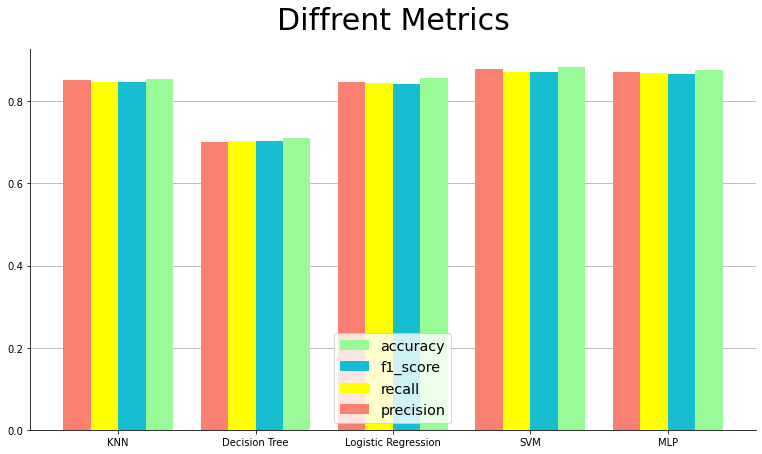

In [139]:
plt.figure(figsize=(13,7))

acc_cv = np.array(accuracy_cv)
clfs = ['KNN','Decision Tree','Logistic Regression','SVM','MLP']
r1 = np.arange(len(clfs))
r2 = [x + 0.2 for x in r1]
r3 = [x - 0.2 for x in r1]
r4 = [x - 0.4 for x in r1]

plt.bar(r2, accuracy,  width = 0.2, color = 'palegreen', label='accuracy', zorder=5)
plt.bar(r1, f1_score,  width = 0.2, color = 'tab:cyan', label='f1_score', zorder=5)
plt.bar(r3, recall,    width = 0.2, color = 'yellow', label='recall', zorder=5)
plt.bar(r4, precision, width = 0.2, color = 'salmon', label='precision', zorder=5)

plt.xticks([r - 0.1 for r in range(len(clfs))], clfs)
plt.grid(axis='y', zorder=0)
plt.legend(loc=8, fontsize='x-large')
plt.title('Diffrent Metrics', fontsize=30, pad=20)
sns.despine(right=True)

### Cross Validation Accuracy

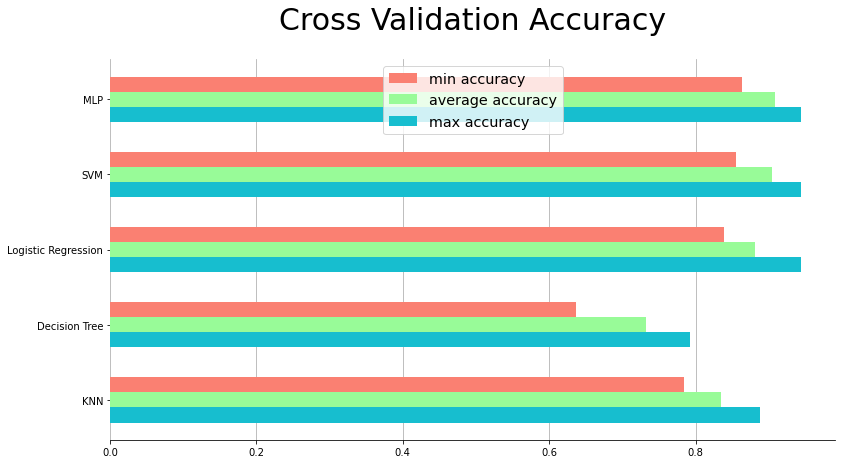

In [140]:
plt.figure(figsize=(13,7))

acc_cv = np.array(accuracy_cv)
clfs = ['KNN','Decision Tree','Logistic Regression','SVM','MLP']
r1 = np.arange(len(clfs))
r2 = [x + 0.2 for x in r1]
r3 = [x - 0.2 for x in r1]

plt.barh(r2, acc_cv[:,0], height = 0.2, color = 'salmon', label='min accuracy', zorder=5)
plt.barh(r1, acc_cv[:,1], height = 0.2, color = 'palegreen', label='average accuracy', zorder=5)
plt.barh(r3, acc_cv[:,2], height = 0.2, color = 'tab:cyan', label='max accuracy', zorder=5)

plt.yticks(range(len(clfs)), clfs)
plt.grid(axis='x', zorder=0)
plt.legend(loc=9, fontsize='x-large')
plt.title('Cross Validation Accuracy', fontsize=30, pad=30)
sns.despine(right=True, left=True)

### Confusion Matrix

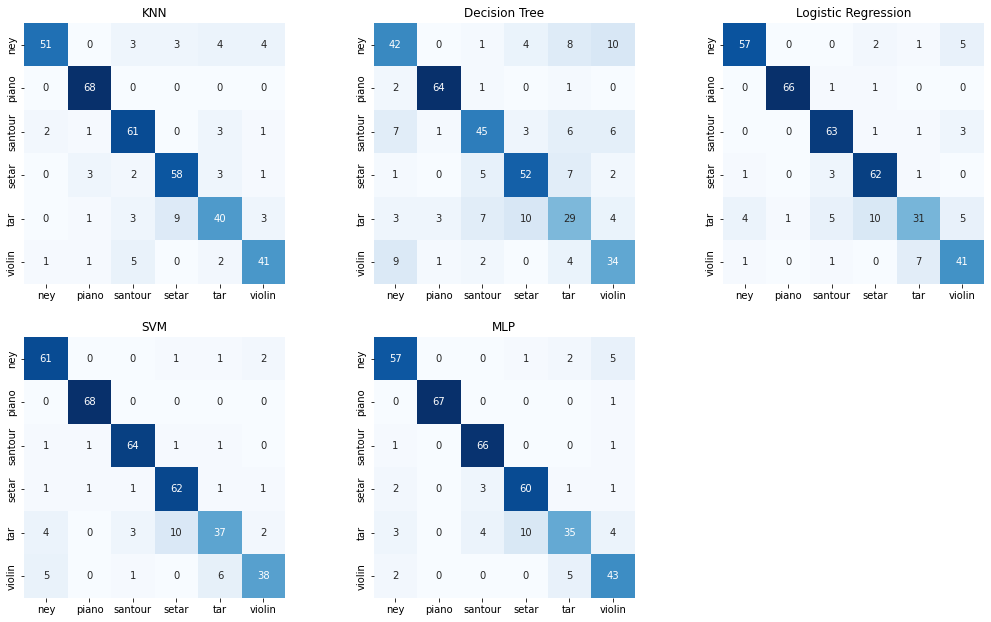

In [134]:
def cnfsn(i, ax):
    sns.heatmap(confusion_mtrx[i], annot=True, cmap=plt.cm.Blues, square=True, ax=ax, cbar=False,
                xticklabels=labelencoder.classes_ , yticklabels=labelencoder.classes_)
    ax.set_title(clfs[i])

fig = plt.figure(figsize=(15,9))

ax1 = fig.add_subplot(2,3,1)
cnfsn(0, ax1)
ax2 = fig.add_subplot(2,3,2)
cnfsn(1, ax2)
ax3 = fig.add_subplot(2,3,3)
cnfsn(2, ax3)
ax4 = fig.add_subplot(2,3,4)
cnfsn(3, ax4)
ax5 = fig.add_subplot(2,3,5)
cnfsn(4, ax5)


plt.tight_layout(pad=2)

---

---
# *Clustering* 
---

### Loading Data

In [4]:
with open('X.pickle', 'rb') as f: #loads the file from hard disk
    X = pickle.load(f)
    
with open('labels.pickle', 'rb') as f: #loads the file from hard disk
    labels = pickle.load(f)

### Labeling

In [5]:
# encoding labels using LabelEncoder in sklearn
labelencoder = LabelEncoder()
labelencoder.fit(labels)
y = labelencoder.transform(labels)

### Metrics function

In [6]:
def clustering_fit_stats(estimator, name, data):
    
    t0 = time()
    y_pred = estimator.fit_predict(data)
    
    print('%-9s\t%.3fs\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f  %.3f'
          % (name, (time() - t0),
             metrics.adjusted_rand_score(y, y_pred),
             metrics.adjusted_mutual_info_score(y, y_pred),
             metrics.normalized_mutual_info_score(y, y_pred),
             metrics.homogeneity_score(y, y_pred),
             metrics.completeness_score(y, y_pred),
             metrics.v_measure_score(y,y_pred),
             metrics.silhouette_score(X, y_pred, metric='euclidean'),
             metrics.calinski_harabasz_score(X, y_pred),
             metrics.davies_bouldin_score(X, y_pred)))

### Standardizing

In [7]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X.shape

(1244, 26)

### UMAP Feature Reduction

In [8]:
# !conda install -c conda-forge umap-learn

In [9]:
from umap import UMAP

reduced_X = UMAP(random_state=0).fit_transform(X)
reduced_X.shape

(1244, 2)

---

# K-Means

### Fitting

In [10]:
def kmean(n, x):
    kmeans_model = KMeans(n_clusters= n, random_state=0)
    y_pred = kmeans_model.fit_predict(x)
    return (y_pred)

### Contingency Matrix of Diffrent Clusters

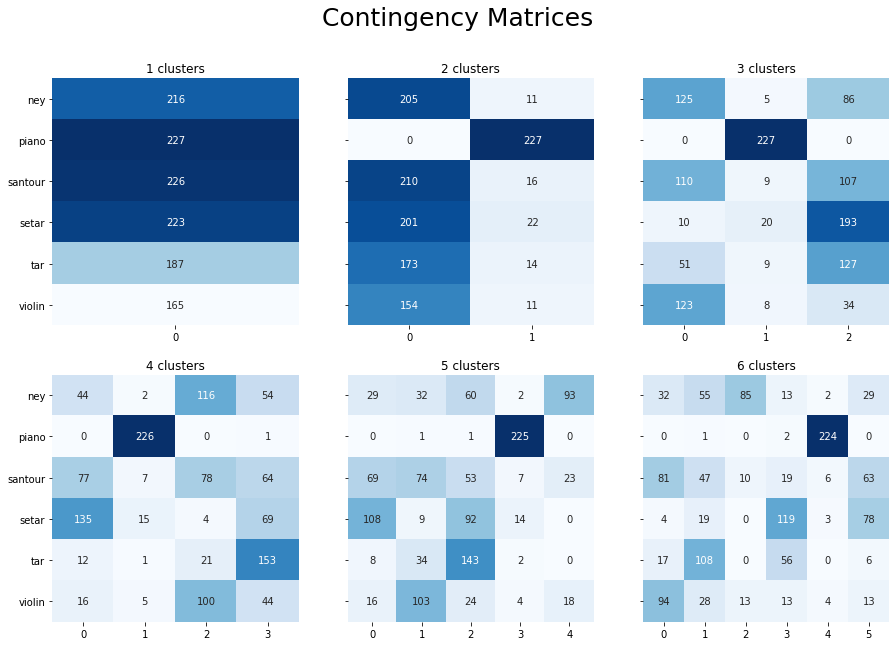

In [11]:
fig, axe = plt.subplots(2,3, figsize=(15,10), sharey=True)

for i in range(0,6):
    ax = axe.flat[i]
    sns.heatmap(metrics.cluster.contingency_matrix(y, kmean(i+1, X)), annot=True, cmap=plt.cm.Blues, cbar=False, 
                ax=ax, fmt='d')
    ax.yaxis.set_ticklabels(rotation=0, ticklabels=labelencoder.classes_)
    ax.set_title(str(i+1)+' clusters')
    
fig.suptitle('Contingency Matrices', fontsize=25);

### Metrics

In [12]:
print('\n')
print('type\t\t\ttime\tR-Score\tAMI\tNMI\tHomo\tComp\tV-meas\tSilh\tCH-score  DB-score')
print(110 * '_')

clustering_fit_stats(KMeans(n_clusters= 2, random_state= 0), name="K-means with k=2", data= X)
clustering_fit_stats(KMeans(n_clusters= 3, random_state= 0), name="K-means with k=3", data= X)
clustering_fit_stats(KMeans(n_clusters= 4, random_state= 0), name="K-means with k=4", data= X)
clustering_fit_stats(KMeans(n_clusters= 5, random_state= 0), name="K-means with k=5", data= X)
clustering_fit_stats(KMeans(n_clusters= 6, random_state= 0), name="K-means with k=6", data= X)
clustering_fit_stats(KMeans(n_clusters= 6, random_state= 0), name="K-means with k=6 & UMAP", data= reduced_X)




type			time	R-Score	AMI	NMI	Homo	Comp	V-meas	Silh	CH-score  DB-score
______________________________________________________________________________________________________________
K-means with k=2	0.111s	0.148	0.291	0.292	0.191	0.618	0.292	0.150	225.527  1.745
K-means with k=3	0.094s	0.247	0.339	0.341	0.272	0.456	0.341	0.155	208.216  2.163
K-means with k=4	0.144s	0.296	0.365	0.368	0.326	0.423	0.368	0.140	187.359  2.054
K-means with k=5	0.104s	0.307	0.373	0.376	0.352	0.403	0.376	0.148	170.683  2.017
K-means with k=6	0.153s	0.340	0.394	0.398	0.395	0.401	0.398	0.140	155.776  2.011
K-means with k=6 & UMAP	0.099s	0.439	0.470	0.473	0.473	0.473	0.473	0.109	128.474  2.312


### Kmeans with UMAP feature reduction
#### Contingency Matrix & 2d visualizing ( with UMAP feature reduction to 2 components )

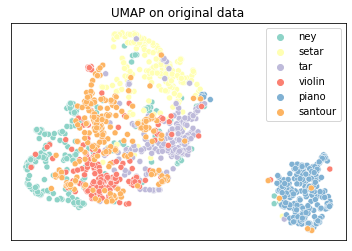

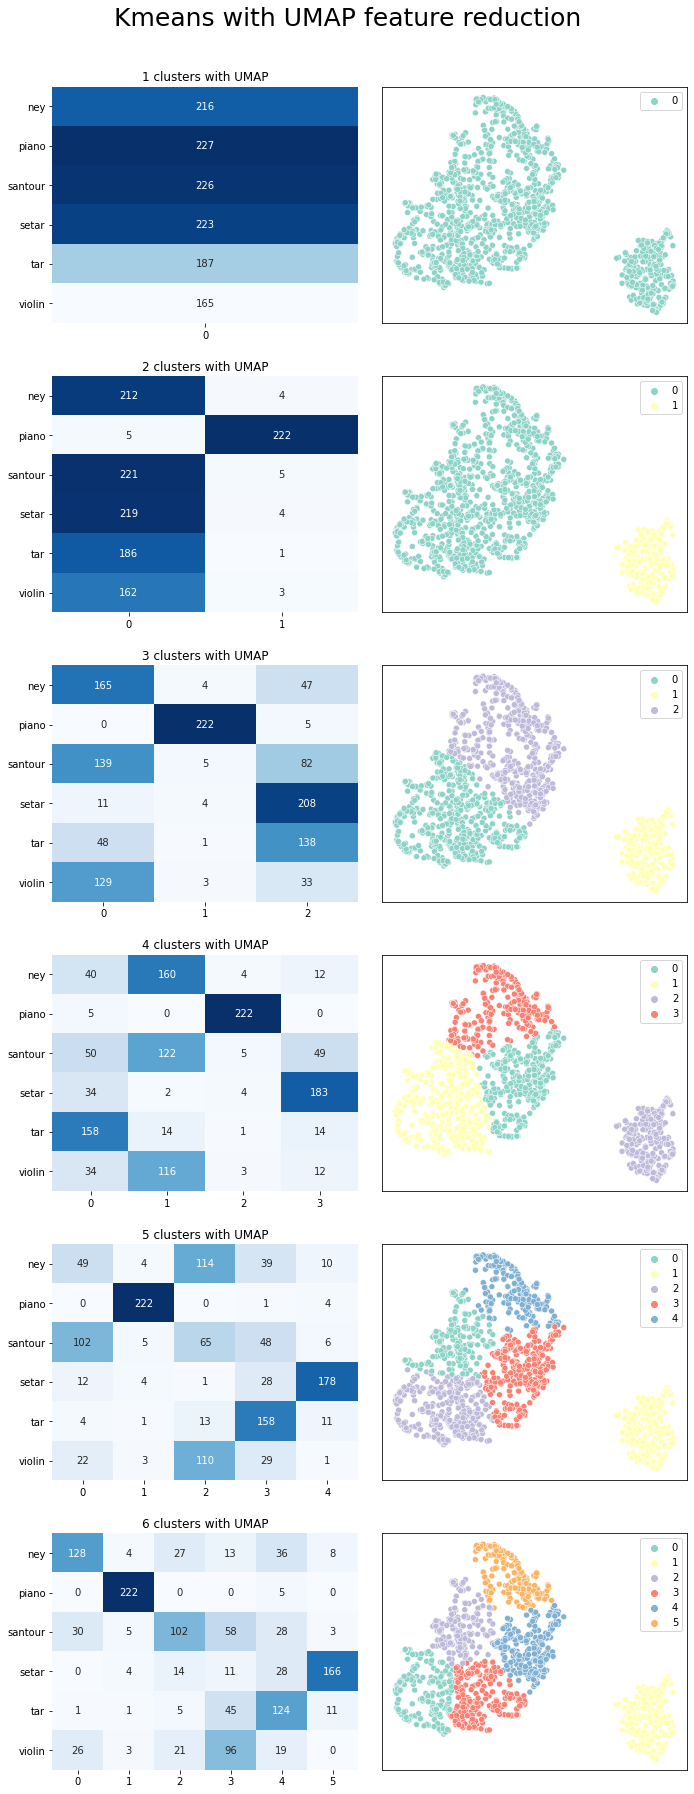

In [13]:
plt.figure()
sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=labels, palette='Set3')
plt.xticks(())
plt.yticks(())
plt.title('UMAP on original data')


fig, axe = plt.subplots(6,2, figsize=(10,25))
for i in range(0,6):
    ypred = kmean(i+1, reduced_X)
    sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
                ax=axe.flat[i*2], yticklabels=labelencoder.classes_, fmt='d')
    sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=ypred, palette='Set3', ax=axe.flat[i*2+1])
    axe.flat[i*2+1].set_xticks(())
    axe.flat[i*2+1].set_yticks(())
    axe.flat[i*2].set_title(str(i+1)+' clusters with UMAP')

fig.suptitle('Kmeans with UMAP feature reduction', fontsize=25, y=1)
plt.tight_layout(pad=2);

---

## Agglomerative Clustering

### Fitting

In [14]:
def aggcltrng(n, x):
    ac_model = AgglomerativeClustering(n_clusters=n, linkage='ward')
    y_pred = ac_model.fit_predict(x)
    return (y_pred)

### Contingency Matrix of Diffrent Clusters

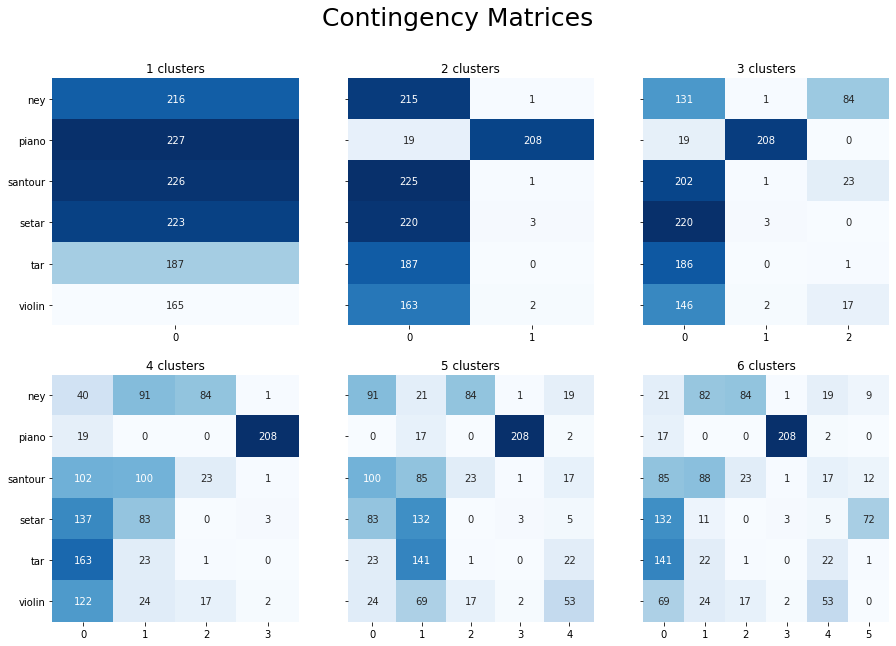

In [15]:
fig, axe = plt.subplots(2,3, figsize=(15,10), sharey=True)

for i in range(0,6):
    ax = axe.flat[i]
    sns.heatmap(metrics.cluster.contingency_matrix(y, aggcltrng(i+1, X)), annot=True, cmap=plt.cm.Blues, cbar=False, 
                ax=ax, fmt='d')
    ax.yaxis.set_ticklabels(rotation=0, ticklabels=labelencoder.classes_)
    ax.set_title(str(i+1)+' clusters')
    
fig.suptitle('Contingency Matrices', fontsize=25);

### Metrics

In [16]:
print('\n')
print('type\t\t\t\t\ttime\tR-Score\tAMI\tNMI\tHomo\tComp\tV-meas\tSilh\tCH-score  DB-score')
print(120 * '_')

clustering_fit_stats(AgglomerativeClustering(n_clusters= 2, linkage='ward'), name="Agglomerative with 2 clusters       ", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters= 3, linkage='ward'), name="Agglomerative with 3 clusters       ", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters= 4, linkage='ward'), name="Agglomerative with 4 clusters       ", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters= 5, linkage='ward'), name="Agglomerative with 5 clusters       ", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters= 6, linkage='ward'), name="Agglomerative with 6 clusters       ", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters= 6, linkage='ward'), name="Agglomerative with 6 clusters & UMAP", data= reduced_X)




type					time	R-Score	AMI	NMI	Homo	Comp	V-meas	Silh	CH-score  DB-score
________________________________________________________________________________________________________________________
Agglomerative with 2 clusters       	0.143s	0.128	0.334	0.335	0.211	0.817	0.335	0.141	200.262  1.522
Agglomerative with 3 clusters       	0.131s	0.154	0.357	0.359	0.256	0.598	0.359	0.151	157.979  2.030
Agglomerative with 4 clusters       	0.089s	0.216	0.346	0.349	0.296	0.426	0.349	0.114	149.179  2.337
Agglomerative with 5 clusters       	0.088s	0.245	0.342	0.345	0.315	0.382	0.345	0.099	133.072  2.299
Agglomerative with 6 clusters       	0.090s	0.267	0.369	0.373	0.357	0.390	0.373	0.100	120.492  2.395
Agglomerative with 6 clusters & UMAP	0.101s	0.367	0.431	0.434	0.429	0.440	0.434	0.114	128.927  2.334


### Agglomerative Clustering with UMAP feature reduction
#### Contingency Matrix & 2d visualizing ( with UMAP feature reduction to 2 components )

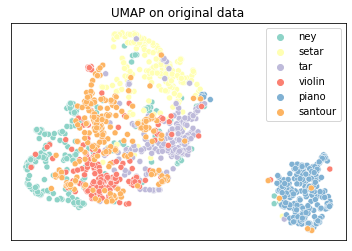

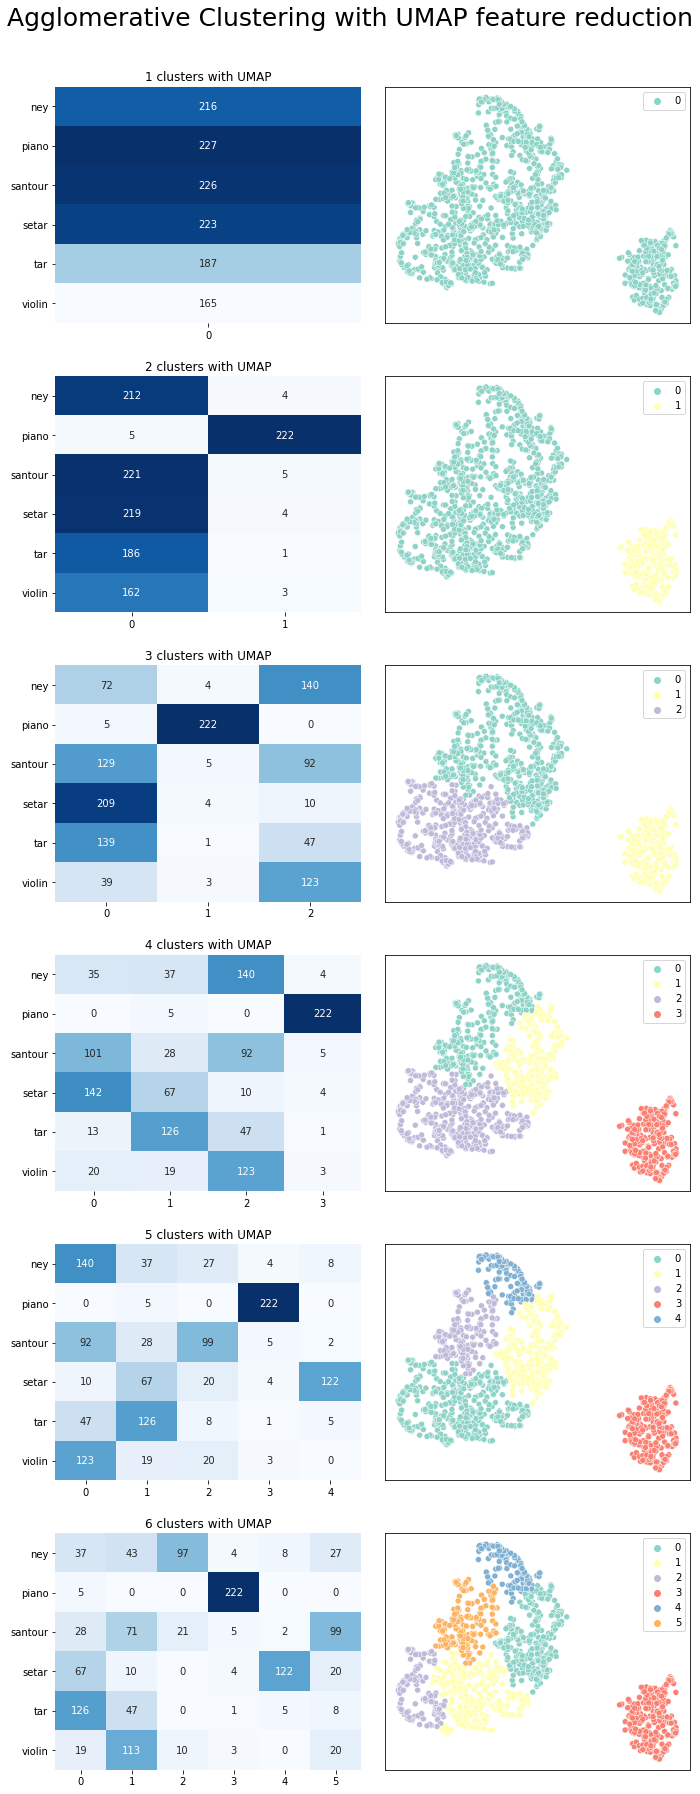

In [17]:
plt.figure()
sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=labels, palette='Set3')
plt.xticks(())
plt.yticks(())
plt.title('UMAP on original data')


fig, axe = plt.subplots(6,2, figsize=(10,25))
for i in range(0,6):
    ypred = aggcltrng(i+1, reduced_X)
    sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
                ax=axe.flat[i*2], yticklabels=labelencoder.classes_, fmt='d')
    sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=ypred, palette='Set3', ax=axe.flat[i*2+1])
    axe.flat[i*2+1].set_xticks(())
    axe.flat[i*2+1].set_yticks(())
    axe.flat[i*2].set_title(str(i+1)+' clusters with UMAP')

fig.suptitle('Agglomerative Clustering with UMAP feature reduction', fontsize=25, y=1)
plt.tight_layout(pad=2);

---

# Gaussian Mixture

### Fitting

In [18]:
def gsmx(n, x):
    gm_model = GaussianMixture(n_components=n, random_state=0)
    y_pred = gm_model.fit_predict(x)
    return (y_pred)

### Contingency Matrix of Diffrent Clusters

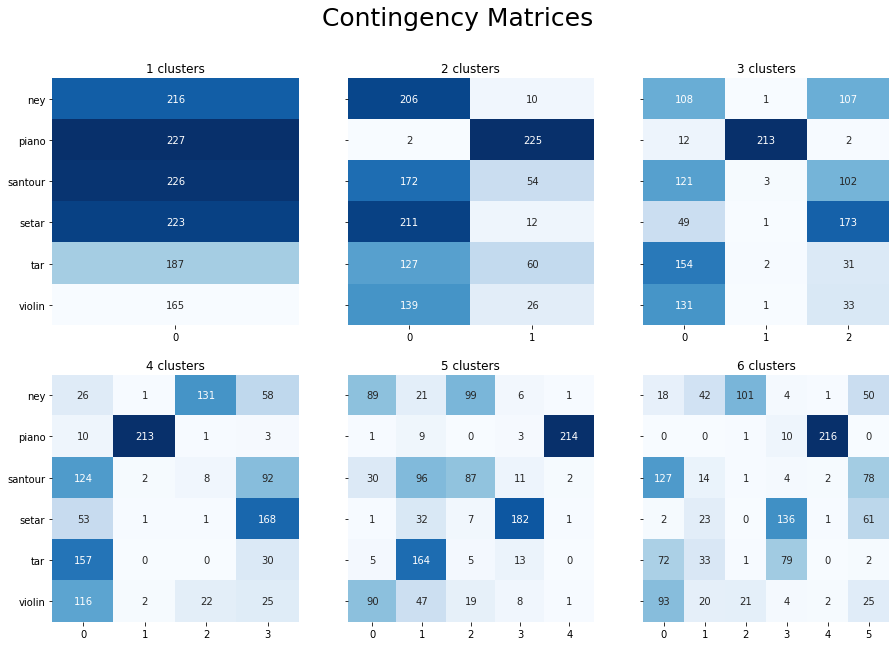

In [19]:
fig, axe = plt.subplots(2,3, figsize=(15,10), sharey=True)

for i in range(0,6):
    ax = axe.flat[i]
    sns.heatmap(metrics.cluster.contingency_matrix(y, gsmx(i+1, X)), annot=True, cmap=plt.cm.Blues, cbar=False, 
                ax=ax, fmt='d')
    ax.yaxis.set_ticklabels(rotation=0, ticklabels=labelencoder.classes_)
    ax.set_title(str(i+1)+' clusters')
    
fig.suptitle('Contingency Matrices', fontsize=25);

### Metrics

In [20]:
print('\n')
print('type\t\t\t\t\ttime\tR-Score\tAMI\tNMI\tHomo\tComp\tV-meas\tSilh\tCH-score  DB-score')
print(120 * '_')

clustering_fit_stats(GaussianMixture(n_components=2, random_state=0), name="Gaussian Mixture with 2 clusters       ", data= X)
clustering_fit_stats(GaussianMixture(n_components=3, random_state=0), name="Gaussian Mixture with 3 clusters       ", data= X)
clustering_fit_stats(GaussianMixture(n_components=4, random_state=0), name="Gaussian Mixture with 4 clusters       ", data= X)
clustering_fit_stats(GaussianMixture(n_components=5, random_state=0), name="Gaussian Mixture with 5 clusters       ", data= X)
clustering_fit_stats(GaussianMixture(n_components=6, random_state=0), name="Gaussian Mixture with 6 clusters       ", data= X)
clustering_fit_stats(GaussianMixture(n_components=6, random_state=0), name="Gaussian Mixture with 6 clusters & UMAP", data= reduced_X)




type					time	R-Score	AMI	NMI	Homo	Comp	V-meas	Silh	CH-score  DB-score
________________________________________________________________________________________________________________________
Gaussian Mixture with 2 clusters       	0.123s	0.143	0.239	0.240	0.162	0.466	0.240	0.116	188.899  2.152
Gaussian Mixture with 3 clusters       	0.203s	0.219	0.337	0.338	0.267	0.462	0.338	0.111	165.675  2.591
Gaussian Mixture with 4 clusters       	0.215s	0.303	0.415	0.418	0.361	0.495	0.418	0.109	144.080  2.403
Gaussian Mixture with 5 clusters       	0.241s	0.411	0.474	0.476	0.449	0.507	0.476	0.106	132.806  2.400
Gaussian Mixture with 6 clusters       	0.344s	0.362	0.443	0.446	0.441	0.451	0.446	0.094	112.217  2.908
Gaussian Mixture with 6 clusters & UMAP	0.043s	0.426	0.458	0.461	0.460	0.462	0.461	0.113	130.404  2.219


### Gaussian Mixture with UMAP feature reduction
#### Contingency Matrix & 2d visualizing ( with UMAP feature reduction to 2 components )

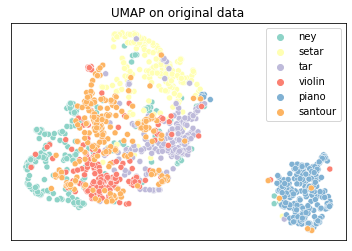

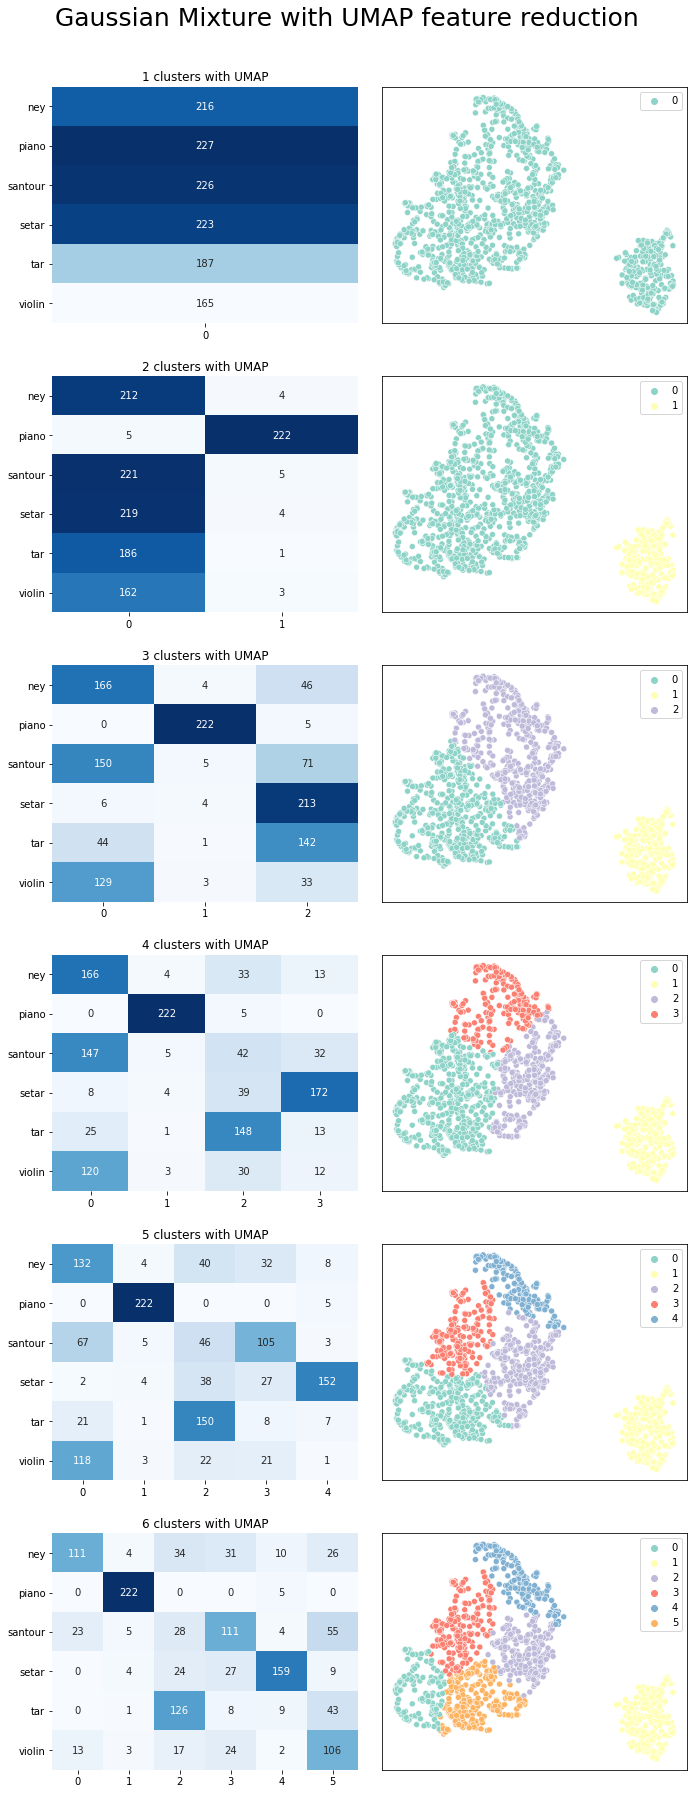

In [21]:
plt.figure()
sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=labels, palette='Set3')
plt.xticks(())
plt.yticks(())
plt.title('UMAP on original data')


fig, axe = plt.subplots(6,2, figsize=(10,25))
for i in range(0,6):
    ypred = gsmx(i+1, reduced_X)
    sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
                ax=axe.flat[i*2], yticklabels=labelencoder.classes_, fmt='d')
    sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=ypred, palette='Set3', ax=axe.flat[i*2+1])
    axe.flat[i*2+1].set_xticks(())
    axe.flat[i*2+1].set_yticks(())
    axe.flat[i*2].set_title(str(i+1)+' clusters with UMAP')

fig.suptitle('Gaussian Mixture with UMAP feature reduction', fontsize=25, y=1)
plt.tight_layout(pad=2);

---

# Comparison

### Visualizations

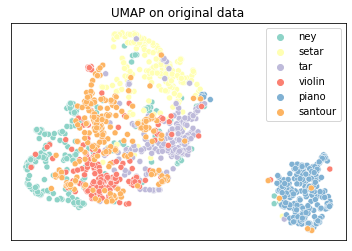

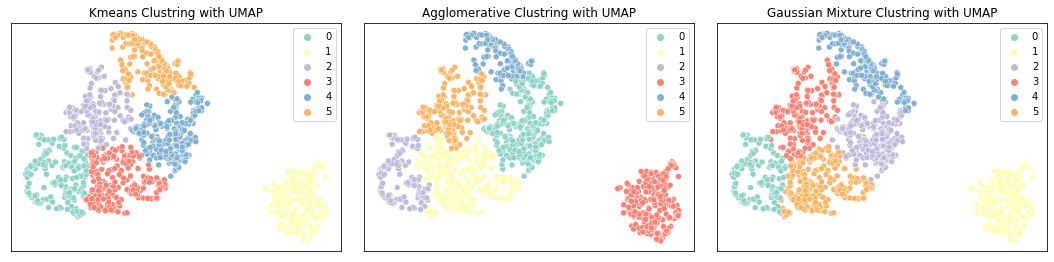

In [22]:
plt.figure()
sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=labels, palette='Set3')
plt.xticks(())
plt.yticks(())
plt.title('UMAP on original data')

plt.figure(figsize=(15,4))
plt.subplot(131)
sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=kmean(6, reduced_X), palette='Set3')
plt.xticks(())
plt.yticks(())
plt.title('Kmeans Clustring with UMAP')
plt.subplot(132)
sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=aggcltrng(6, reduced_X), palette='Set3')
plt.xticks(())
plt.yticks(())
plt.title('Agglomerative Clustring with UMAP')
plt.subplot(133)
sns.scatterplot(reduced_X[:,0], reduced_X[:,1], hue=gsmx(6, reduced_X), palette='Set3')
plt.xticks(())
plt.yticks(())
plt.title('Gaussian Mixture Clustring with UMAP')
plt.tight_layout(pad=2);

### Metrics

In [23]:
print('\n')
print('type\t\t\ttime\tR-Score\tAMI\tNMI\tHomo\tComp\tV-meas\tSilh\tCH-score  DB-score')
print(100 * '_')

clustering_fit_stats(KMeans(n_clusters= 6, random_state= 0),            name="K-means                ", data= X)
clustering_fit_stats(KMeans(n_clusters= 6, random_state= 0),            name="K-means with UMAP      ", data= reduced_X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=6) ,            name="Agglomerative          ", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=6) ,            name="Agglomerative with UMAP", data= reduced_X)
clustering_fit_stats(GaussianMixture(n_components= 6, random_state= 0), name="GMM                    ", data= X)
clustering_fit_stats(GaussianMixture(n_components= 6, random_state= 0), name="GMM with UMAP          ", data= reduced_X)



type			time	R-Score	AMI	NMI	Homo	Comp	V-meas	Silh	CH-score  DB-score
____________________________________________________________________________________________________
K-means                	0.141s	0.340	0.394	0.398	0.395	0.401	0.398	0.140	155.776  2.011
K-means with UMAP      	0.108s	0.439	0.470	0.473	0.473	0.473	0.473	0.109	128.474  2.312
Agglomerative          	0.086s	0.267	0.369	0.373	0.357	0.390	0.373	0.100	120.492  2.395
Agglomerative with UMAP	0.063s	0.367	0.431	0.434	0.429	0.440	0.434	0.114	128.927  2.334
GMM                    	0.349s	0.362	0.443	0.446	0.441	0.451	0.446	0.094	112.217  2.908
GMM with UMAP          	0.041s	0.426	0.458	0.461	0.460	0.462	0.461	0.113	130.404  2.219


### Contingency Matrices

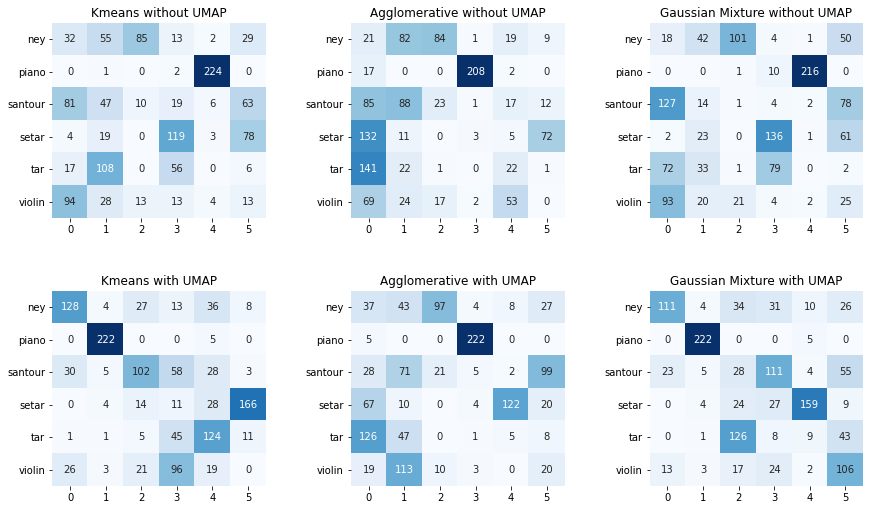

In [24]:
plt.figure(figsize=(13,8))

plt.subplot(231)
ypred = kmean(6, X)
sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
            yticklabels=labelencoder.classes_, fmt='d')
plt.yticks(rotation=0)
plt.title('Kmeans without UMAP')
plt.subplot(234)
ypred = kmean(6, reduced_X)
sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
            yticklabels=labelencoder.classes_, fmt='d')
plt.yticks(rotation=0)
plt.title('Kmeans with UMAP')

plt.subplot(232)
ypred = aggcltrng(6, X)
sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
            yticklabels=labelencoder.classes_, fmt='d')
plt.yticks(rotation=0)
plt.title('Agglomerative without UMAP')
plt.subplot(235)
ypred = aggcltrng(6, reduced_X)
sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
            yticklabels=labelencoder.classes_, fmt='d')
plt.yticks(rotation=0)
plt.title('Agglomerative with UMAP')

plt.subplot(233)
ypred = gsmx(6, X)
sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
            yticklabels=labelencoder.classes_, fmt='d')
plt.yticks(rotation=0)
plt.title('Gaussian Mixture without UMAP')
plt.subplot(236)
ypred = gsmx(6, reduced_X)
sns.heatmap(metrics.cluster.contingency_matrix(y, ypred), annot=True, cmap=plt.cm.Blues, cbar=False, 
            yticklabels=labelencoder.classes_, fmt='d')
plt.yticks(rotation=0)
plt.title('Gaussian Mixture with UMAP')

plt.tight_layout(pad=4);

---
---